# Setup do Projeto

In [1]:
# Testando CUDA
import torch
print(f"CUDA está disponível: {torch.cuda.is_available()}\nDevice count: {torch.cuda.device_count()}\nNome do dispositivo: {torch.cuda.get_device_name(0)}\nVersao do PyTorch: {torch.__version__}")

CUDA está disponível: True
Device count: 2
Nome do dispositivo: AMD Radeon RX 7800 XT
Versao do PyTorch: 2.9.1+rocm7.2.0.git7e1940d4


In [2]:
# Setup Agnostic Code for GPU/CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Constantes
DATA_PATH = '/home/jose-vitor/Documents/Cityscapes_Dataset'

IM_HEIGHT = 256
IM_WIDTH = 512

BATCH_SIZE = 64
NUM_WORKERS = 4

# Preparando o Dataset Cityscapes

In [4]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
from torchvision import tv_tensors  # <--- Importação necessária pára Augmentations
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import ast # converte string que representa as cor para tupla
import random

Definir Lables

In [5]:
# Importar tabela de lables
lables_df = pd.read_csv('labels_cityscapes.csv')

# Excluir lablel -1 (classe não usada)
# Substitur trainID de 255 para 19 para facilitar a conversao
lables_df = lables_df[lables_df['trainID'] != -1].replace({'trainID': {255: 19}})

# Converter coluna de cor de string para tupla
lables_df['color'] = lables_df['color'].apply(ast.literal_eval) # ast.literal_eval() eh uma funcao que converte strings para formatos numericos correspondentes

# Criar novo dataframe com labels usados para treino
train_lables_df = lables_df[lables_df['trainID'] != 19].drop(columns=['id', 'trainID']) # remove classes nao usadas no treino e colunas desnecessarias
train_lables_df.loc[-1] = ['ignore', 'ignore', 255, False, True, (0, 0, 0)]  # adiciona linha para classe ignore, que deve ser desconsiderada no treino
train_lables_df = train_lables_df.reset_index(drop=True) # reseta os indexes
train_lables_df

,name,category,catID,hasinstances,ignoreInEval,color
0,road,flat,1,False,False,"(128, 64, 128)"
1,sidewalk,flat,1,False,False,"(244, 35, 232)"
2,building,construction,2,False,False,"(70, 70, 70)"
3,wall,construction,2,False,False,"(102, 102, 156)"
4,fence,construction,2,False,False,"(190, 153, 153)"
5,pole,object,3,False,False,"(153, 153, 153)"
6,traffic light,object,3,False,False,"(250, 170, 30)"
7,traffic sign,object,3,False,False,"(220, 220, 0)"
8,vegetation,nature,4,False,False,"(107, 142, 35)"
9,terrain,nature,4,False,False,"(152, 251, 152)"


In [6]:
# Definindo dicionario para conversao de ids para treino
id_to_trainid = dict(zip(lables_df['id'], lables_df['trainID']))
id_to_trainid;

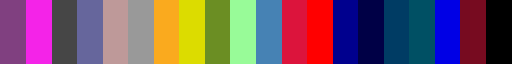

In [7]:
# Criando o color map para imprimir imagens segmentadas
train_color_map = train_lables_df['color'].to_list()
train_color_map = ['#%02x%02x%02x' % color for color in train_color_map]
cmap = mcolors.LinearSegmentedColormap.from_list('CityscapesTrainColorMap', train_color_map, N=len(train_color_map))
cmap

# Importar o Dataset Cityscapes

Definir Funções de Transform

In [8]:
# Funcoes personalizadas para transformacoes

# -- 1. remove canal extra desnecessário na segmentação
mask_squeeze = lambda x: x.squeeze(dim=0)

# -- 2. transforma os ids originais para ids de treino
class IdToTrainIdTransform:

    def __init__(self, conv_dict: dict):
        self.conv_dict = conv_dict

    def __call__(self, mask: torch.Tensor) -> torch.Tensor:
        new_mask = mask # cria uma copia da mascara original para ser modificada
        # Troca os valores da mascara original a partir do dicionario
        for lable, new_lable in list(self.conv_dict.items()):
            # Caso o pixel esteja com a mascara da key, troca para a mascara do value, caso contrario mantem a mascara original
            new_mask = torch.where(mask == lable, new_lable, new_mask)
        return new_mask
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

In [9]:
# transformando dados em tensores e aplicando data augmentation
# O dataset original possui tamanho 1024x2048

# -- DATA TRANSFORMS -- #
train_transform = v2.Compose([
    v2.Resize(size=(IM_HEIGHT,IM_WIDTH), interpolation=InterpolationMode.BILINEAR), # redimensiona imagem para 256x512
    v2.PILToTensor(), # converte imagem PIL para tensor
    v2.ToDtype(torch.uint8) # apenas converte para inteiro sem normalizacao
])

val_transform = v2.Compose([
    v2.Resize(size=(IM_HEIGHT,IM_WIDTH), interpolation=InterpolationMode.BILINEAR), # redimensiona imagem para 256x512
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

# -- TARGET TRANFROMS -- #
target_transform = v2.Compose([
    v2.PILToTensor(), # converte segmentação PIL para tensor
    IdToTrainIdTransform(id_to_trainid), # converte ids originais para ids de treino
    v2.Resize(size=(IM_HEIGHT,IM_WIDTH), interpolation=InterpolationMode.NEAREST_EXACT), # redimensiona imagem para 256x512. Nearest Neighbor para nao criar novos valores
    #v2.Lambda(mask_squeeze), # remove canal extra desnecessário na segmentação
    v2.ToDtype(torch.uint8) # apenas converte para inteiro sem normalizacao
])

# -- DATA AUGMENTATION -- #
data_augmentation = v2.Compose([

    # Transformações Geométricas
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.1),
    v2.RandomRotation(degrees=15, interpolation=InterpolationMode.BILINEAR, expand=False, center=None, fill={tv_tensors.Image: (0,0,0), tv_tensors.Mask: 19}),
    
    # Transformações Fotométricas (O v2 aplica AUTOMATICAMENTE só na Imagem)
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    
    # Opcional: Borrão para simular foco ruim
    v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
])

In [10]:
# Criar Classe para dateset modificado
class AugmentedCityscapes(datasets.Cityscapes):
    def __init__(self, *args, data_augmentation=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_augmentation = data_augmentation

    def __getitem__(self, index: int):
        image, target = super().__getitem__(index)

        # Aplicar data augmentation se estiver definido
        if self.data_augmentation:

            # tv_tensors informama ao v2 que o 'image' é uma Imagem e 'target' é uma Mascara.
            # Isso garante que rotacoes/flips sejam aplicados em ambos,
            # e que ajustes de cor (se houver) sejam aplicados APENAS na imagem.
            image, target = self.data_augmentation(tv_tensors.Image(image), tv_tensors.Mask(target))

        if self.split == 'train':
            image = v2.ToDtype(torch.float32, scale=True)(image) # normaliza para [0,1]

        return image, target

Importar Dataset

In [11]:
train_dataset = AugmentedCityscapes(DATA_PATH,
                             split = 'train',
                             mode='fine',
                             target_type='semantic',
                             transform=train_transform,
                             target_transform=target_transform,
                             data_augmentation=data_augmentation)
val_dataset = AugmentedCityscapes(DATA_PATH,
                           split = 'val',
                           mode='fine',
                           target_type='semantic',
                           transform=val_transform,
                           target_transform=target_transform)
test_dataset = AugmentedCityscapes(DATA_PATH,
                            split = 'test',
                            mode='fine',
                            target_type='semantic',
                            transform=val_transform,
                            target_transform=target_transform)

In [12]:
# Imprimir informacoes importantes dos datasets
img, smnt = train_dataset[0]
print(f"O Dataset de treino possui {len(train_dataset)} amostras.\n"
      f"O Dataset de validação possui {len(val_dataset)} amostras.\n"
      f"O Dataset de teste possui {len(test_dataset)} amostras.\n"
      f"Cada imagem posssui tamanho {img.shape} e tipo {img.dtype}, e cada mascara possui tamanho {smnt.shape} e tipo {smnt.dtype}.\n")

#print(f"Primeira Imagem do dataset de treino:\n{img}\nPrimenra mascara do dataset de treino:\n{smnt}")

O Dataset de treino possui 2975 amostras.
O Dataset de validação possui 500 amostras.
O Dataset de teste possui 1525 amostras.
Cada imagem posssui tamanho torch.Size([3, 256, 512]) e tipo torch.float32, e cada mascara possui tamanho torch.Size([1, 256, 512]) e tipo torch.uint8.



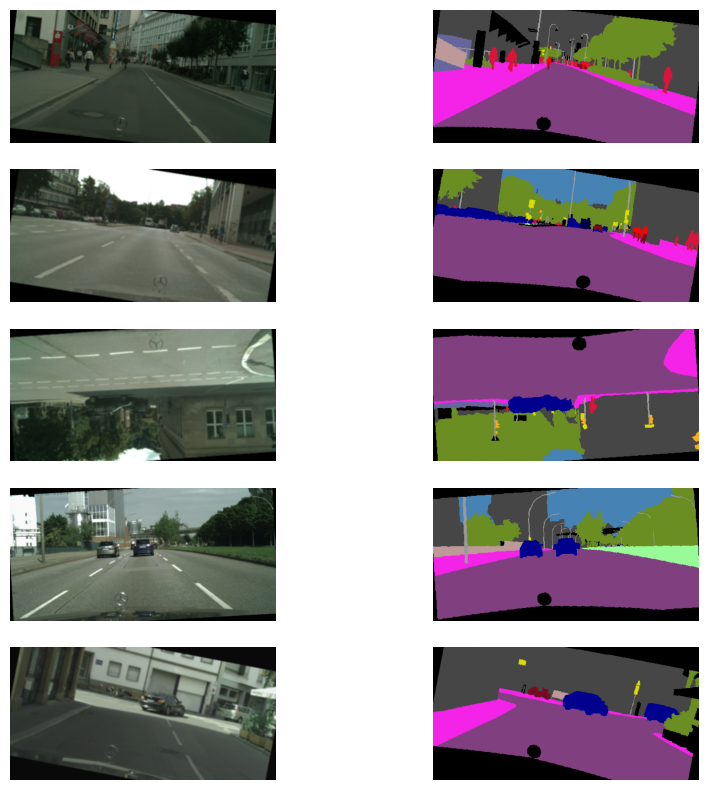

In [13]:
# Imprimindo imagens e segmentações do dataset
def img_show(imgs: list[torch.Tensor], smnts: list[torch.Tensor], n: int=5):    
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(imgs[i].permute(1,2,0)) # permute para mudar a ordem dos canais e converter um tensor para imagem
        plt.axis('off')
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(smnts[i].squeeze(dim=0), cmap=cmap)
        plt.axis('off')

def dataset_show(dataset, n:int = 5):
    img_list = []
    smnt_list = []
    for i in random.sample(range(len(dataset)), k=n):
        img, smnt = dataset[i]
        img_list.append(img)
        smnt_list.append(smnt)
    img_show(img_list, smnt_list, n)

# Testando a funcao de exibicao
dataset_show(train_dataset, n=5)

Criar dataloaders

In [14]:
# Criando datalaoders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [15]:
# Imprimindo informacoes relevantes dos dataloaders
train_features_batch, train_labels_batch = next(iter(train_dataloader))
val_features_batch, val_labels_batch = next(iter(val_dataloader))
print(f"O pacote de imagens para treino possui tamanho: {train_features_batch.size()}, e o tamanho do pacote da mescaras para treino possui tamanho: {train_labels_batch.size()}")
print(f"O pacote de imagens para validacao possui tamanho: {val_features_batch.size()}, e o tamanho do pacote da mescaras para validacao possui tamanho: {val_labels_batch.size()}")

O pacote de imagens para treino possui tamanho: torch.Size([64, 3, 256, 512]), e o tamanho do pacote da mescaras para treino possui tamanho: torch.Size([64, 1, 256, 512])
O pacote de imagens para validacao possui tamanho: torch.Size([64, 3, 256, 512]), e o tamanho do pacote da mescaras para validacao possui tamanho: torch.Size([64, 1, 256, 512])
